## Training for H1 rapgap MC with reconstructed observables as input.
### This uses a single DNN with all inputs (electron, HFS, photons)


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:
#has_gpu = False

has_gpu = True

training_name = 'training_h1_reg_v4b_tau1b_2'




#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9



learning_rate_setval_reg = 1e-5  
batch_size_setval = 1024
max_epochs = 5000
dropout_setval = 0.0
amsgrad_setval = True #####




#input_file = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file = 'MLAssistedUnfolding-files/all-h1-rapgap.root'
input_file = 'rapgap_ep0607_tau1b_2.root'


parfile = open( '%s-setup.txt' % training_name,'w')

parfile.write('%s\n' % datetime.now() )
parfile.write('training_name : %s\n' % training_name )
parfile.write('input_file : %s\n' % input_file )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )
parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )

parfile.close()

print('\n\n--- Training parameters file: %s-setup.txt\n' % training_name )
print( subprocess.getoutput('cat %s-setup.txt' % training_name ) )
print('\n\n')
    




--- Training parameters file: training_h1_reg_v4b_tau1b_2-setup.txt

2021-11-19 09:47:44.466567
training_name : training_h1_reg_v4b_tau1b_2
input_file : rapgap_ep0607_tau1b_2.root
max_events : 1000000000
learning_rate_setval_reg : 1e-05
batch_size_setval : 1024
max_epochs : 5000
dropout_setval : 0
amsgrad_setval : 1





In [3]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     #     'obs_x', 'obs_y', 'obs_Q2',
#     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_phi',  # 'obs_e_pz','obs_e_pt',
     'obs_e_theta',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
#     'obs_dphi',
     'obs_DeltaPhi',
     'obs_e_trk_e',
     # new minimal set of gen-level variables
     'beam_e_e','beam_p_e',
     'gen_HFS_Sigma', 'gen_HFS_T',
     'gen_eUncomb_E', 'gen_eUncomb_theta',
     'gen_eRecomb_E', 'gen_eRecomb_theta',
     # tau1b
     'gen_tau1b',
     'obs_tau1bs','obs_tau1be','obs_tau1bda',
     'obs_cHFSs_M','obs_cHFSs_pt','obs_cHFSs_theta','obs_cHFSs_phi',
    'obs_cHFSs_N',
     'obs_cHFSs_dRavg',
     'obs_cHFSs_dR2avg',
    'obs_cHFSs_Empz',
    'obs_cHFSs_Eppz' ,
    'obs_cHFSe_Empz',
    'obs_cHFSe_Eppz', 
    'obs_cHFSe_keE0',
    'obs_cHFSs_keE0',
    'obs_cHFSs_kesE0',
     # new minimal set of det-level variables 
     #'obs_e_e','obs_e_theta', 
     #'obs_hfs_T','obs_hfs_Sigma'ravg,
     # useful det-level quantities
    'wgt'
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7fd2902af460>
wgt                        (no streamer)              asdtype('>f4')
gen_HFS_Sigma              (no streamer)              asdtype('>f4')
gen_HFS_T                  (no streamer)              asdtype('>f4')
gen_eUncomb_E              (no streamer)              asdtype('>f4')
gen_eUncomb_theta          (no streamer)              asdtype('>f4')
gen_eRecomb_E              (no streamer)              asdtype('>f4')
gen_eRecomb_theta          (no streamer)              asdtype('>f4')
obs_e_theta                (no streamer)              asdtype('>f4')
obs_DeltaPhi               (no streamer)              asdtype('>f4')
gen_tau1b                  (no streamer)              asdtype('>f4')
obs_tau1bs                 (no streamer)              asdtype('>f4')
obs_tau1bda                (no streamer)              asdtype('>f4')
obs_tau1bida               (no streamer)              asdtype('>f4')
obs_tau1be                 (no streamer)           

In [4]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_e_e,obs_e_phi,obs_e_theta,...,obs_cHFSs_dRavg,obs_cHFSs_dR2avg,obs_cHFSs_Empz,obs_cHFSs_Eppz,obs_cHFSe_Empz,obs_cHFSe_Eppz,obs_cHFSe_keE0,obs_cHFSs_keE0,obs_cHFSs_kesE0,wgt
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,1.144036
1,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.008928
2,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.291180
3,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.027073
4,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.008928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60643673,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.016648
60643674,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.039054
60643675,0,1,24.007572,1,-0.637264,2.351282,1.337233,24.007572,-1.859867,2.471095,...,0.499605,0.304052,10.397371,4.823552,10.721814,6.879882,18.18329,0.0,8.007449,0.013066


In [5]:
## tau1b: to be cleaned up

# rename input quantites (temporarily)
#pandas_df.eval( 'obs_e_E         = obs_e_e', inplace=True )
pandas_df.eval( 'obs_e_pz  = obs_e_e*cos(obs_e_theta)', inplace=True )
pandas_df.eval( 'obs_e_pt  = obs_e_e*sin(obs_e_theta)', inplace=True )
#pandas_df.eval( 'obs_e_theta   = arcsin(obs_e_pt/obs_e_E)', inplace=True )
pandas_df.eval( 'obs_hfs_Sigma = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_hfs_T     = obs_hfs_pt', inplace=True )

# useful derived quantites
pandas_df.eval( 'obs_e_Sigma      = obs_e_e - obs_e_pz', inplace=True )
#pandas_df.eval( 'obs_e_tantheta   = sin(obs_e_theta/2.)/cos(obs_e_theta/2.)', inplace=True )
pandas_df.eval( 'obs_e_tantheta   = obs_e_Sigma/obs_e_pt', inplace=True )
pandas_df.eval( 'obs_e_Pt2        = obs_e_pt*obs_e_pt', inplace=True )
pandas_df.eval( 'obs_hfs_tangamma = obs_hfs_Sigma/obs_hfs_pt', inplace=True )

###########################################################
### DIS-DNN originals
###########################################################
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

###########################################################

# inelasticity
pandas_df.eval( 'obs_kine_ye   = 1. - obs_e_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'obs_kine_yda  = obs_hfs_tangamma/(obs_hfs_tangamma+obs_e_tantheta)', inplace=True )
pandas_df.eval( 'obs_kine_yh   = obs_hfs_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'obs_kine_ys   = obs_hfs_Sigma/(obs_hfs_Sigma+obs_e_Sigma)', inplace=True )
#pandas_df.eval( 'obs_kine_yes  = 2.*beam_e_e*obs_hfs_Sigma/(obs_hfs_Sigma+obs_e_Sigma)/(obs_hfs_Sigma+obs_e_Sigma)', inplace=True )

# Q2
pandas_df.eval( 'obs_kine_Q2e   = obs_e_Pt2/(1.-obs_kine_ye)', inplace=True )
pandas_df.eval( 'obs_kine_Q2da  = 4.*beam_e_e*beam_e_e/obs_e_tantheta/(obs_hfs_tangamma+obs_e_tantheta)', inplace=True )
pandas_df.eval( 'obs_kine_Q2s   = obs_e_Pt2/(1.-obs_kine_ys)', inplace=True )
pandas_df.eval( 'obs_kine_Q2ida = obs_e_Pt2/(1.-obs_kine_yda)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2h   = obs_hfs_T*obs_hfs_T/(1.-obs_kine_yh)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2ees = 2.*beam_e_e*(2.*obs_e_e - 2.*beam_e_e + obs_hfs_Sigma)', inplace=True )
#pandas_df.eval( 'obs_kine_Q2ets = 2.*beam_e_e*(2.*beam_e_e - obs_hfs_Sigma) / obs_e_tantheta/obs_e_tantheta', inplace=True )
#pandas_df.eval( 'obs_kine_Q2tsg = obs_hfs_T*obs_hfs_T/(1.-obs_kine_yda) ', inplace=True )
##pandas_df.eval( 'obs_kine_Q2tsg = obs_hfs_Sigma*obs_hfs_Sigma/(obs_hfs_tangamma*obs_hfs_tangamma)/(1.-obs_kine_yda) ', inplace=True )

# x
#pandas_df.eval( 'obs_kine_xe   = 1./beam_p_e * obs_kine_Q2e   /4. /beam_e_e/obs_kine_ye', inplace=True )
#pandas_df.eval( 'obs_kine_xees = 1./beam_p_e * obs_kine_Q2ees /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xets = 1./beam_p_e * obs_kine_Q2ets /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xda  = 1./beam_p_e * obs_kine_Q2da  /4. /beam_e_e/obs_kine_yda', inplace=True )
#pandas_df.eval( 'obs_kine_xh   = 1./beam_p_e * obs_kine_Q2h   /2. /obs_hfs_Sigma', inplace=True )
pandas_df.eval( 'obs_kine_xis  = 1./beam_p_e * obs_kine_Q2s   /2. /obs_hfs_Sigma', inplace=True )
#pandas_df.eval( 'obs_kine_xida = 1./beam_p_e * obs_e_e * (1+cos(obs_e_theta))/2./obs_kine_yda', inplace=True ) #check, if theta is correct?!
#pandas_df.eval( 'obs_kine_xtsg = 1./beam_p_e * obs_kine_Q2tsg /2. /obs_hfs_Sigma', inplace=True )



In [6]:
# gen level DIS-DNN originals 
#pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
#pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
#pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )


# useful derived quantites
pandas_df.eval( 'gen_e_Sigma      = gen_eRecomb_E * (1. - cos(gen_eRecomb_theta))', inplace=True )
pandas_df.eval( 'gen_e_tantheta   = sin(gen_eRecomb_theta/2.)/cos(gen_eRecomb_theta/2.)', inplace=True )
pandas_df.eval( 'gen_e_Pt2        = gen_eRecomb_E*gen_eRecomb_E * sin(gen_eRecomb_theta)* sin(gen_eRecomb_theta)', inplace=True )
pandas_df.eval( 'gen_HFS_tangamma = gen_HFS_Sigma/gen_HFS_T', inplace=True )

# inelasticity
pandas_df.eval( 'gen_kine_ye   = 1. - gen_e_Sigma/2./beam_e_e', inplace=True )
pandas_df.eval( 'gen_kine_yda  = gen_HFS_tangamma/(gen_HFS_tangamma+gen_e_tantheta)', inplace=True )
pandas_df.eval( 'gen_kine_ys   = gen_HFS_Sigma/(gen_HFS_Sigma+gen_e_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_yes  = 2.*beam_e_e*gen_HFS_Sigma/(gen_HFS_Sigma+gen_e_Sigma)/(gen_HFS_Sigma+gen_e_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_yh   = gen_HFS_Sigma/2./beam_e_e', inplace=True )

# Q2
pandas_df.eval( 'gen_kine_Q2e   = gen_e_Pt2/(1.-gen_kine_ye)', inplace=True )
pandas_df.eval( 'gen_kine_Q2da  = 4.*beam_e_e*beam_e_e/gen_e_tantheta/(gen_HFS_tangamma+gen_e_tantheta)', inplace=True )
pandas_df.eval( 'gen_kine_Q2s   = gen_e_Pt2/(1.-gen_kine_ys)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2h   = gen_HFS_T*gen_HFS_T/(1.-gen_kine_yh)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ida = gen_e_Pt2/(1.-gen_kine_yda)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ees = 2.*beam_e_e*(2.*gen_eRecomb_E - 2.*beam_e_e + gen_HFS_Sigma)', inplace=True )
#pandas_df.eval( 'gen_kine_Q2ets = 2.*beam_e_e*(2.*beam_e_e - gen_HFS_Sigma) / gen_e_tantheta/gen_e_tantheta', inplace=True )
#pandas_df.eval( 'gen_kine_Q2tsg = gen_HFS_T*gen_HFS_T/(1.-gen_kine_yda) ', inplace=True )
##pandas_df.eval( 'gen_kine_Q2tsg = gen_HFS_Sigma*gen_HFS_Sigma/(gen_HFS_tangamma*gen_HFS_tangamma)/(1.-gen_kine_yda) ', inplace=True )

# x
#pandas_df.eval( 'gen_kine_xe   = 1./beam_p_e * gen_kine_Q2e   /4. /beam_e_e/gen_kine_ye', inplace=True )
#pandas_df.eval( 'gen_kine_xees = 1./beam_p_e * gen_kine_Q2ees /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xets = 1./beam_p_e * gen_kine_Q2ets /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xda  = 1./beam_p_e * gen_kine_Q2da  /4. /beam_e_e/gen_kine_yda', inplace=True )
#pandas_df.eval( 'gen_kine_xh   = 1./beam_p_e * gen_kine_Q2h   /2. /gen_HFS_Sigma', inplace=True )
pandas_df.eval( 'gen_kine_xis  = 1./beam_p_e * gen_kine_Q2s   /2. /gen_HFS_Sigma', inplace=True )
#pandas_df.eval( 'gen_kine_xida = 1./beam_p_e * gen_eRecomb_E * (1+cos(gen_eRecomb_theta))/2./gen_kine_yda', inplace=True )
#pandas_df.eval( 'gen_kine_xtsg = 1./beam_p_e * gen_kine_Q2tsg /2. /gen_HFS_Sigma', inplace=True )

# target variables
pandas_df.eval( 'gen_log_x  = log(gen_kine_xis)', inplace=True )
pandas_df.eval( 'gen_log_y  = log(gen_kine_ys)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(gen_kine_Q2s)', inplace=True )


In [7]:


pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



## Apply any event selection here.

In [8]:
pandas_df = pandas_df.query('obs_event_Empz > 0')

pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

pandas_df = pandas_df.query('gen_kine_Q2s > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )



 Number of entries in pandas_df:  12211058 


In [9]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_e_e,obs_e_phi,obs_e_theta,...,gen_kine_ys,gen_kine_Q2e,gen_kine_Q2da,gen_kine_Q2s,gen_kine_xis,gen_log_x,gen_log_y,gen_log_Q2,obs_ptbal,obs_pzbal
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,24.247692,2.850790,2.364390,...,0.279064,373.235443,373.231964,373.238831,0.013168,-4.329961,-1.276314,5.922218,0.060719,-0.101689
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,13.348120,2.319518,2.331559,...,0.564190,232.664780,231.641632,232.913391,0.004060,-5.506522,-0.572364,5.450667,-0.035760,0.033116
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,25.104801,-0.609275,2.545624,...,0.201073,226.868393,226.866501,226.870300,0.011109,-4.500025,-1.604089,5.424378,0.168212,-0.079415
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,20.143602,0.875722,2.452950,...,0.320914,268.274323,268.272034,268.276611,0.008231,-4.799892,-1.136582,5.592019,0.091957,0.035842
56,1,0,32.968731,1,0.195189,0.114277,0.189013,32.968731,-2.829920,2.114908,...,0.053120,912.337341,921.025330,903.603821,0.169098,-1.777280,-2.935195,6.806391,0.052082,0.024048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60643653,0,0,26.402330,1,0.174245,0.566415,2.864766,26.402330,-0.330596,2.214237,...,0.256100,577.795593,577.790527,577.800598,0.022213,-3.807077,-1.362187,6.359229,0.021586,-0.037633
60643661,0,0,28.854366,3,1.585496,0.847493,-0.978673,27.674616,2.601410,2.611356,...,0.029831,228.176895,228.174728,228.179047,0.075310,-2.586144,-3.512219,5.430130,0.082591,0.041026
60643662,0,0,20.172613,1,-0.271558,2.526228,-2.976105,20.172613,-0.367923,2.446705,...,0.346926,262.034210,262.031921,262.036438,0.007436,-4.901364,-1.058645,5.568483,-0.055354,0.033951


array([[<AxesSubplot:title={'center':'gen_log_x'}>,
        <AxesSubplot:title={'center':'gen_log_y'}>],
       [<AxesSubplot:title={'center':'gen_log_Q2'}>,
        <AxesSubplot:title={'center':'obs_event_Empz'}>]], dtype=object)

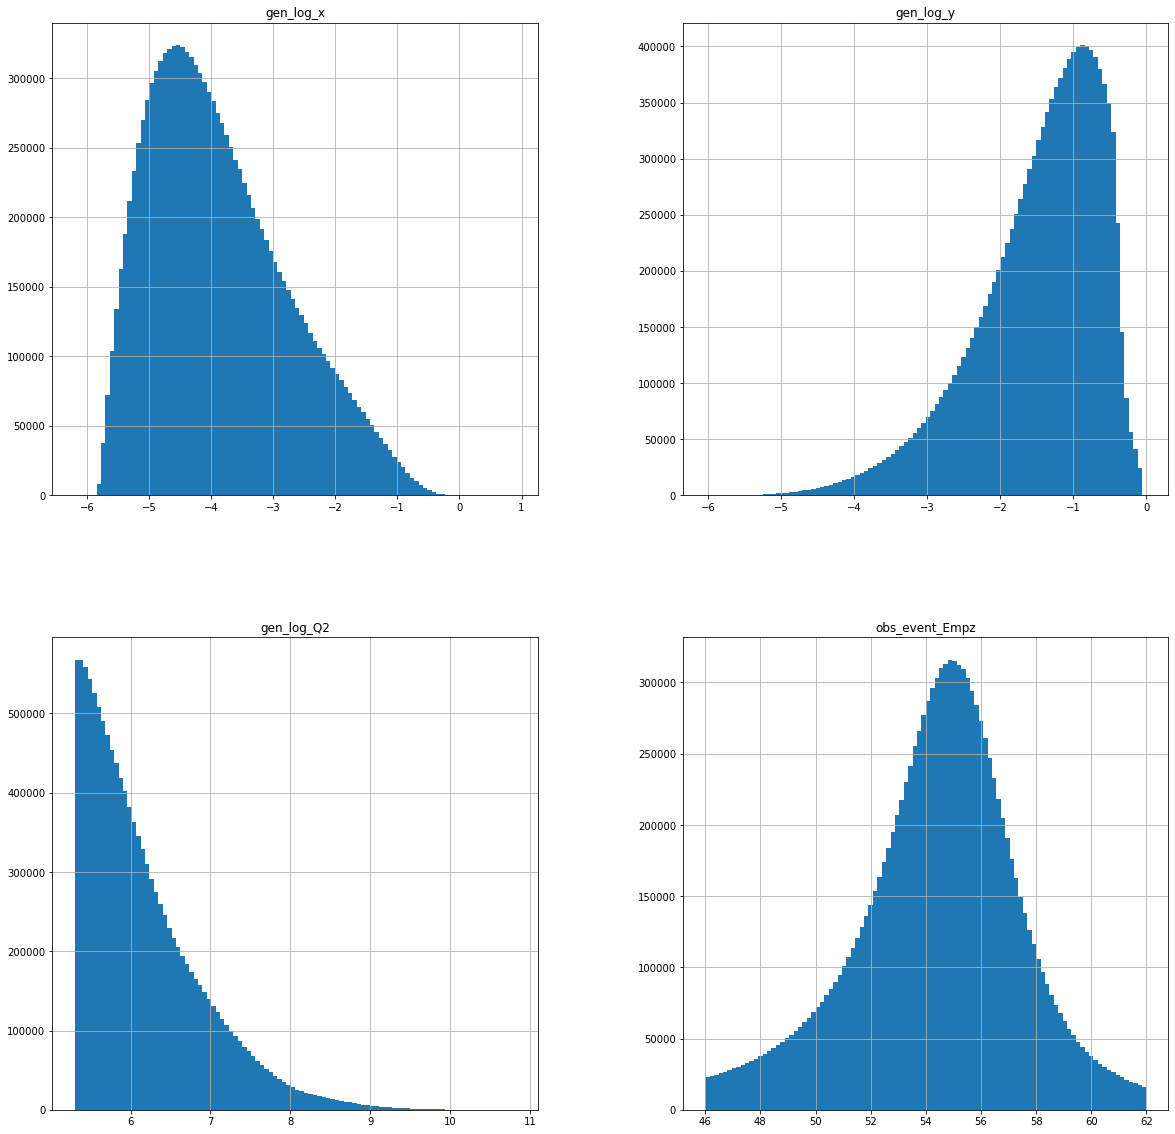

In [10]:
pandas_df.hist( figsize=(20,20), bins=100, column=[#'from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz', 
                        ])
#plt.show()

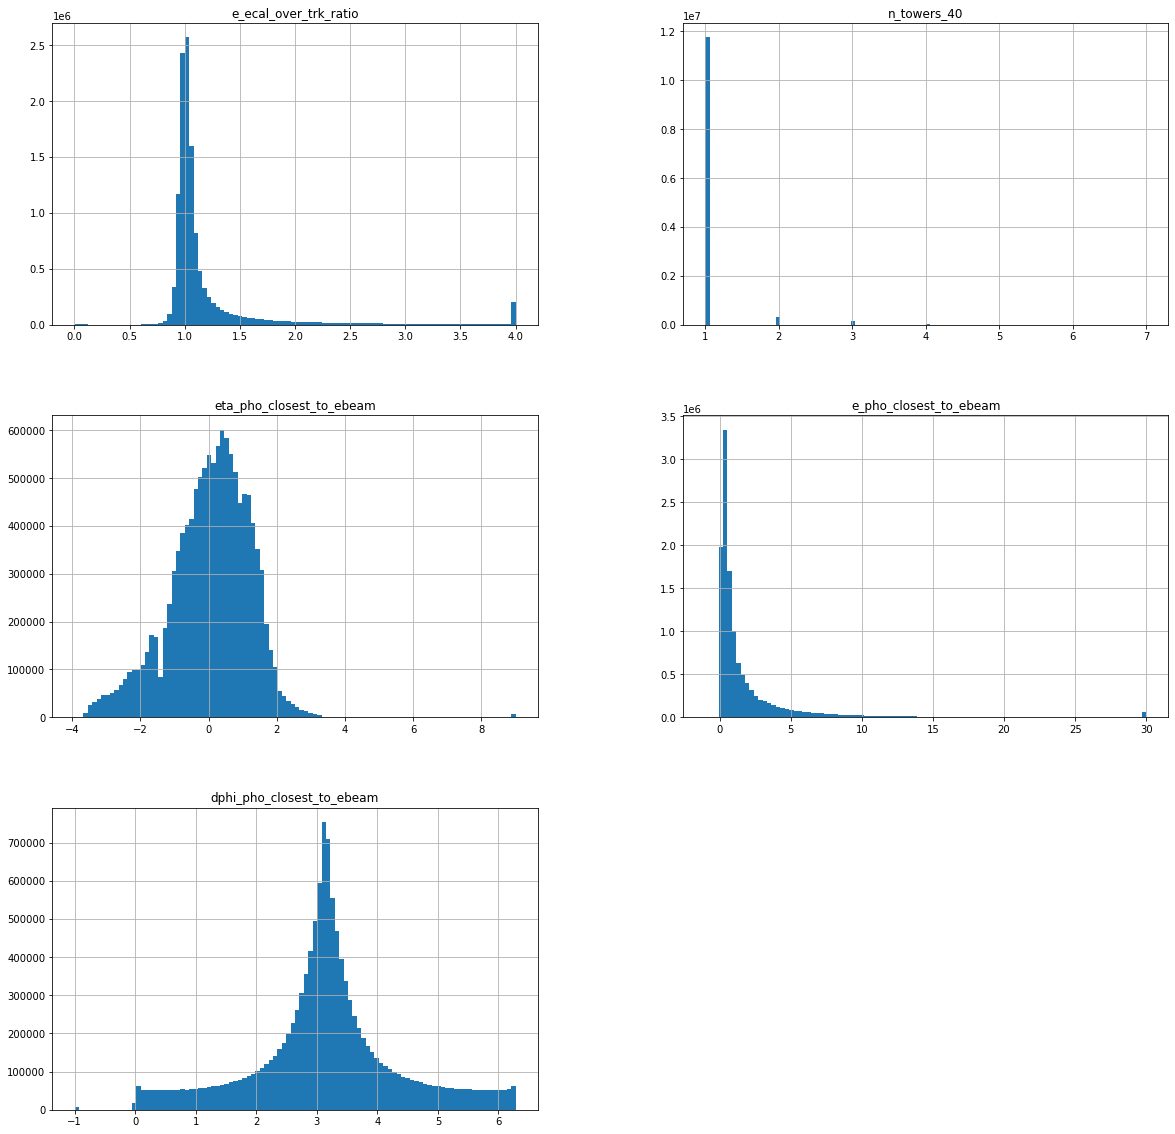

In [11]:

pandas_df.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


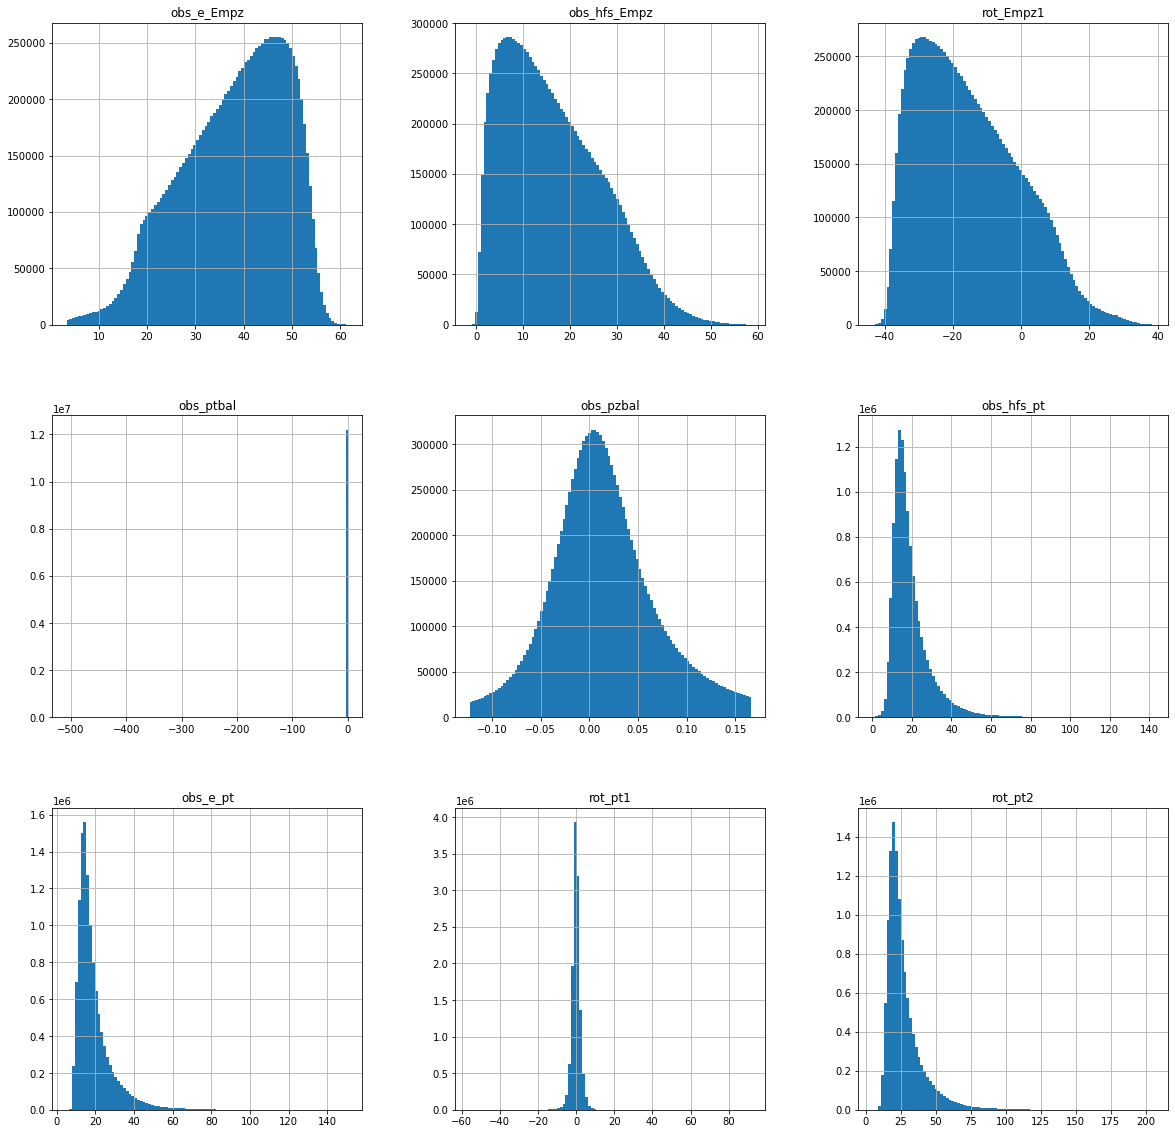

In [12]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump


import os

X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['dphi_pho_closest_to_ebeam'].to_numpy(),
#    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
    pandas_df['obs_pzbal'].to_numpy(),
    pandas_df['obs_ptbal'].to_numpy(),
    pandas_df['obs_DeltaPhi'].to_numpy(),
    pandas_df['obs_kine_ys'].to_numpy(),

    pandas_df['obs_cHFSs_pt'].to_numpy(),
    pandas_df['obs_cHFSs_M'].to_numpy(),
    pandas_df['obs_cHFSs_theta'].to_numpy(),
    pandas_df['obs_cHFSs_phi'].to_numpy(),
    pandas_df['obs_cHFSs_N'].to_numpy(),
    pandas_df['obs_cHFSs_dRavg'].to_numpy(),
    
    pandas_df['obs_cHFSs_dR2avg'].to_numpy(),
    pandas_df['obs_cHFSs_Empz'].to_numpy(),
    pandas_df['obs_cHFSs_Eppz'].to_numpy(),
    pandas_df['obs_cHFSe_Empz'].to_numpy(),
    pandas_df['obs_cHFSe_Eppz'].to_numpy(), 
    pandas_df['obs_cHFSe_keE0'].to_numpy(),
    pandas_df['obs_cHFSs_keE0'].to_numpy(),
    pandas_df['obs_cHFSs_kesE0'].to_numpy(),

]


#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
    pandas_df['gen_tau1b'].to_numpy(),
]

    
GY = pandas_df['gen_kine_ys'].to_numpy()
GQ2 = pandas_df['gen_kine_Q2s'].to_numpy()
Gtau = pandas_df['gen_tau1b'].to_numpy()
Rtau = pandas_df['obs_tau1bs'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_name )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_name )

    
print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_name )
print('    %s-scalers/target_scaler.pkl' % training_name )

dump( scaler, open('%s-scalers/input_scaler.pkl' % training_name , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_name , 'wb'))


X_train, X_test,  Y_r_train, Y_r_test,    GY_train, GY_test,    GQ2_train, GQ2_test,    Gtau_train, Gtau_test,    Rtau_train, Rtau_test  = train_test_split( X, Y_r, GY,GQ2,Gtau,Rtau,  test_size=0.2)
    


  Dir training_h1_reg_v4b_tau1b_2-scalers already exists




 Saving the input and learning target scalers:

    training_h1_reg_v4b_tau1b_2-scalers/input_scaler.pkl
    training_h1_reg_v4b_tau1b_2-scalers/target_scaler.pkl


In [19]:
os.environ['CUDA_VISIBLE_DEVICES']="0"

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential

print(tf.config.list_physical_devices())

if has_gpu :
#    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


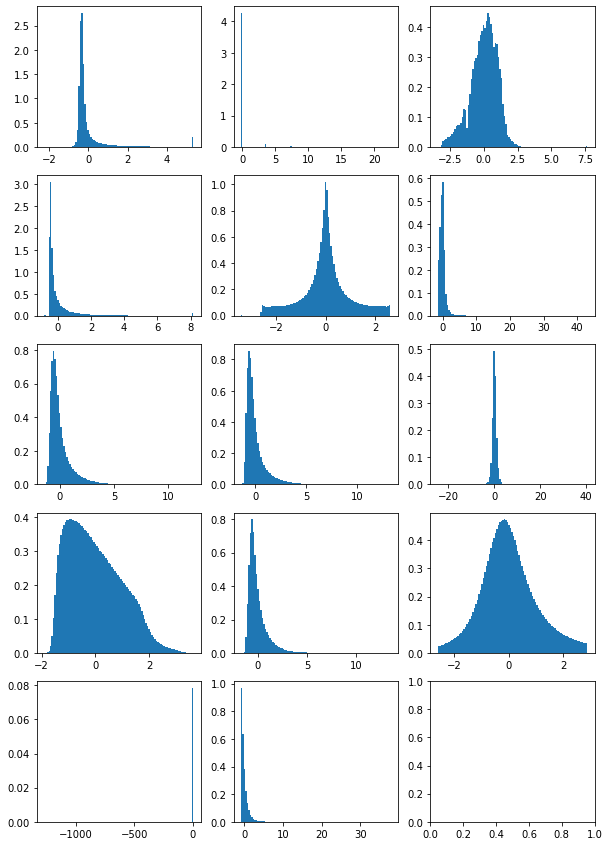

In [20]:
fig,ax = plt.subplots(5,3,figsize=(10,15))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )
ax[4][1].hist( X[:,13], density=True, bins=100 )




plt.show()

In [21]:
print(len(X[0]))
print(len(Y_r[0]))

29
4


## Set up the regression network

In [22]:
model_r = Sequential()

#-- initial layer
model_r.add(Dense(64, input_dim=len(X[0]), activation='relu'))
model_r.add(Dropout(dropout_setval))

#-- middle part
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(1024, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))

#-- final layers
model_r.add(Dense(64, activation='selu'))
model_r.add(Dense(len(Y_r[0]), activation='linear'))

opt_r = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval_reg, amsgrad=amsgrad_setval )
myloss_r = tf.keras.losses.Huber()

model_r.compile(loss=myloss_r, optimizer=opt_r, metrics=['accuracy'])

model_r.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1920      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

In [23]:
%%time

EarlyStopping_patience=10
batch_size_setval = 2048

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=EarlyStopping_patience,
               verbose=True,
               restore_best_weights=True)

hist_r = model_r.fit(
    X_train, Y_r_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_r_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
4770/4770 [==============================] - 25s 5ms/step - loss: 0.0458 - accuracy: 0.8606 - val_loss: 0.0326 - val_accuracy: 0.8823
Epoch 2/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0295 - accuracy: 0.8888 - val_loss: 0.0275 - val_accuracy: 0.8932
Epoch 3/5000
4770/4770 [==============================] - 24s 5ms/step - loss: 0.0260 - accuracy: 0.8965 - val_loss: 0.0250 - val_accuracy: 0.8994
Epoch 4/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0241 - accuracy: 0.9013 - val_loss: 0.0234 - val_accuracy: 0.9033
Epoch 5/5000
4770/4770 [==============================] - 24s 5ms/step - loss: 0.0228 - accuracy: 0.9045 - val_loss: 0.0224 - val_accuracy: 0.9057
Epoch 6/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0219 - accuracy: 0.9069 - val_loss: 0.0215 - val_accuracy: 0.9083
Epoch 7/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0212 - accuracy: 0.9087 - val_loss: 0

4770/4770 [==============================] - 23s 5ms/step - loss: 0.0158 - accuracy: 0.9239 - val_loss: 0.0159 - val_accuracy: 0.9240
Epoch 57/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0158 - accuracy: 0.9240 - val_loss: 0.0158 - val_accuracy: 0.9242
Epoch 58/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0157 - accuracy: 0.9241 - val_loss: 0.0160 - val_accuracy: 0.9238
Epoch 59/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0157 - accuracy: 0.9242 - val_loss: 0.0158 - val_accuracy: 0.9244
Epoch 60/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0157 - accuracy: 0.9242 - val_loss: 0.0159 - val_accuracy: 0.9241
Epoch 61/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0157 - accuracy: 0.9243 - val_loss: 0.0157 - val_accuracy: 0.9245
Epoch 62/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0156 - accuracy: 0.9244 - val_loss: 0.0157 -

4770/4770 [==============================] - 23s 5ms/step - loss: 0.0145 - accuracy: 0.9279 - val_loss: 0.0148 - val_accuracy: 0.9277
Epoch 112/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0145 - accuracy: 0.9280 - val_loss: 0.0146 - val_accuracy: 0.9280
Epoch 113/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0145 - accuracy: 0.9280 - val_loss: 0.0146 - val_accuracy: 0.9280
Epoch 114/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0145 - accuracy: 0.9281 - val_loss: 0.0148 - val_accuracy: 0.9280
Epoch 115/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0144 - accuracy: 0.9282 - val_loss: 0.0146 - val_accuracy: 0.9280
Epoch 116/5000
4770/4770 [==============================] - 24s 5ms/step - loss: 0.0144 - accuracy: 0.9283 - val_loss: 0.0146 - val_accuracy: 0.9279
Epoch 117/5000
4770/4770 [==============================] - 23s 5ms/step - loss: 0.0144 - accuracy: 0.9284 - val_loss: 0.

4770/4770 [==============================] - 20s 4ms/step - loss: 0.0133 - accuracy: 0.9329 - val_loss: 0.0135 - val_accuracy: 0.9326
Epoch 167/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0133 - accuracy: 0.9329 - val_loss: 0.0134 - val_accuracy: 0.9329
Epoch 168/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0133 - accuracy: 0.9330 - val_loss: 0.0136 - val_accuracy: 0.9327
Epoch 169/5000
4770/4770 [==============================] - 19s 4ms/step - loss: 0.0133 - accuracy: 0.9331 - val_loss: 0.0134 - val_accuracy: 0.9329
Epoch 170/5000
4770/4770 [==============================] - 20s 4ms/step - loss: 0.0133 - accuracy: 0.9332 - val_loss: 0.0135 - val_accuracy: 0.9326
Epoch 171/5000
4770/4770 [==============================] - 20s 4ms/step - loss: 0.0133 - accuracy: 0.9333 - val_loss: 0.0137 - val_accuracy: 0.9325
Epoch 172/5000
4770/4770 [==============================] - 20s 4ms/step - loss: 0.0132 - accuracy: 0.9334 - val_loss: 0.

4770/4770 [==============================] - 21s 4ms/step - loss: 0.0126 - accuracy: 0.9361 - val_loss: 0.0127 - val_accuracy: 0.9360
Epoch 222/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0126 - accuracy: 0.9361 - val_loss: 0.0128 - val_accuracy: 0.9356
Epoch 223/5000
4770/4770 [==============================] - 20s 4ms/step - loss: 0.0126 - accuracy: 0.9362 - val_loss: 0.0127 - val_accuracy: 0.9359
Epoch 224/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0126 - accuracy: 0.9362 - val_loss: 0.0130 - val_accuracy: 0.9351
Epoch 225/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0126 - accuracy: 0.9363 - val_loss: 0.0127 - val_accuracy: 0.9363
Epoch 226/5000
4770/4770 [==============================] - 20s 4ms/step - loss: 0.0126 - accuracy: 0.9363 - val_loss: 0.0126 - val_accuracy: 0.9365
Epoch 227/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0125 - accuracy: 0.9364 - val_loss: 0.

4770/4770 [==============================] - 20s 4ms/step - loss: 0.0122 - accuracy: 0.9377 - val_loss: 0.0123 - val_accuracy: 0.9377
Epoch 277/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0122 - accuracy: 0.9378 - val_loss: 0.0125 - val_accuracy: 0.9372
Epoch 278/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0122 - accuracy: 0.9378 - val_loss: 0.0124 - val_accuracy: 0.9373
Epoch 279/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0121 - accuracy: 0.9378 - val_loss: 0.0123 - val_accuracy: 0.9378
Epoch 280/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0121 - accuracy: 0.9379 - val_loss: 0.0125 - val_accuracy: 0.9372
Epoch 281/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0121 - accuracy: 0.9379 - val_loss: 0.0123 - val_accuracy: 0.9376
Epoch 282/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0121 - accuracy: 0.9379 - val_loss: 0.

4770/4770 [==============================] - 21s 4ms/step - loss: 0.0119 - accuracy: 0.9389 - val_loss: 0.0120 - val_accuracy: 0.9388
Epoch 332/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0119 - accuracy: 0.9389 - val_loss: 0.0121 - val_accuracy: 0.9384
Epoch 333/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0118 - accuracy: 0.9389 - val_loss: 0.0121 - val_accuracy: 0.9385
Epoch 334/5000
4770/4770 [==============================] - 21s 4ms/step - loss: 0.0118 - accuracy: 0.9389 - val_loss: 0.0120 - val_accuracy: 0.9389
Epoch 335/5000
4770/4770 [==============================] - 22s 5ms/step - loss: 0.0118 - accuracy: 0.9389 - val_loss: 0.0120 - val_accuracy: 0.9389
Epoch 336/5000
4770/4770 [==============================] - 22s 5ms/step - loss: 0.0118 - accuracy: 0.9390 - val_loss: 0.0120 - val_accuracy: 0.9385
Epoch 337/5000
4770/4770 [==============================] - 22s 5ms/step - loss: 0.0118 - accuracy: 0.9389 - val_loss: 0.

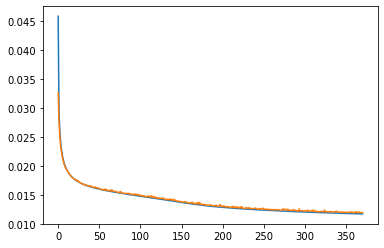

In [24]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])

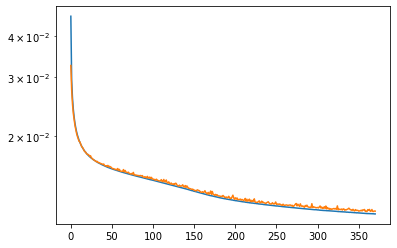

In [25]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])
plt.yscale('log')

In [26]:
tf.keras.models.save_model(model_r, '%s_regression' % training_name )

INFO:tensorflow:Assets written to: training_h1_reg_v4b_tau1b_2_regression/assets


In [27]:
mypreds_r = model_r.predict(X_test,batch_size=1000)

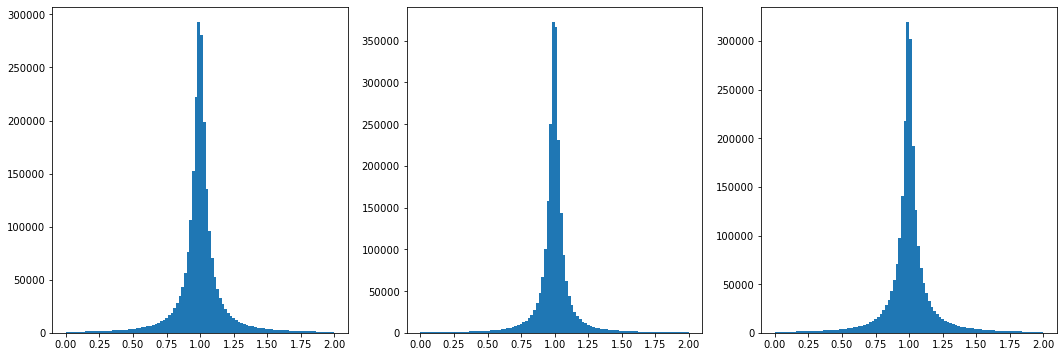

In [28]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

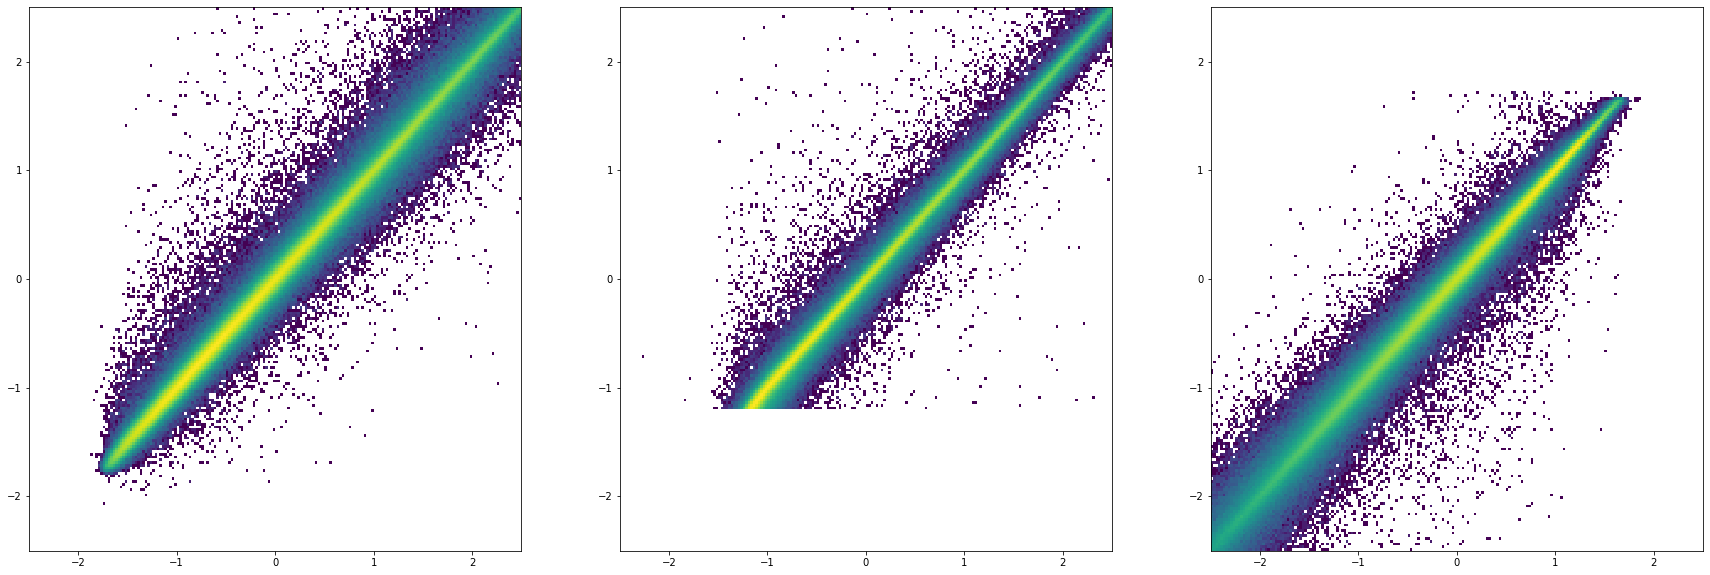

In [29]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [30]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

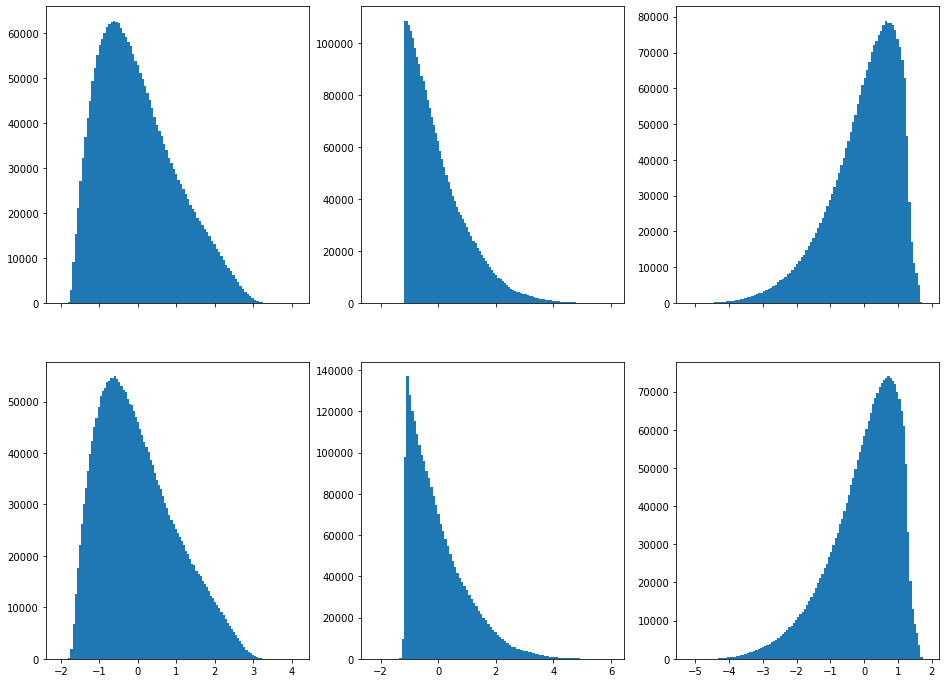

In [31]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

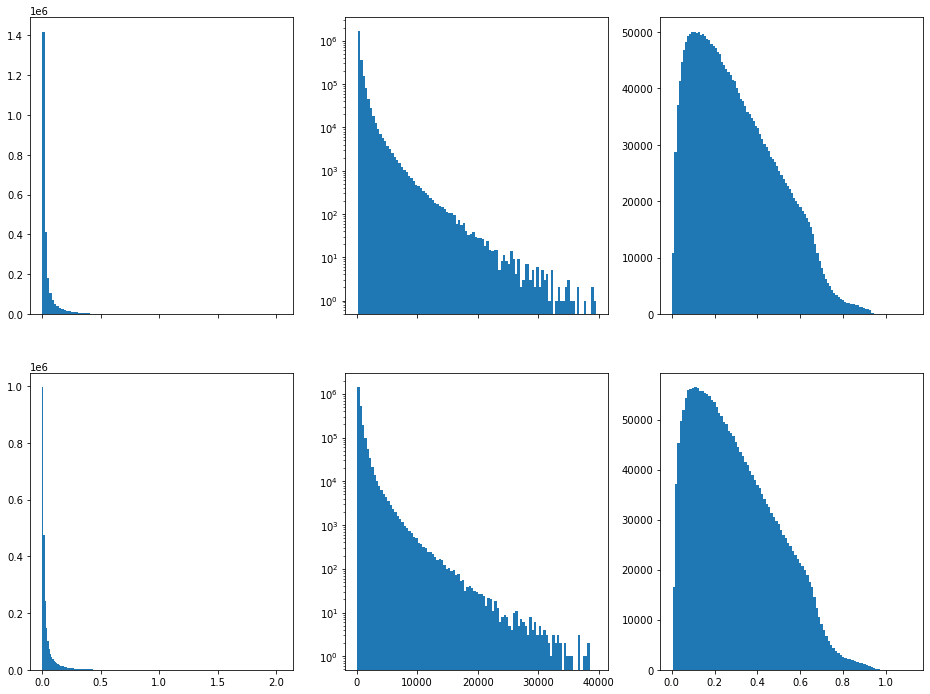

In [32]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

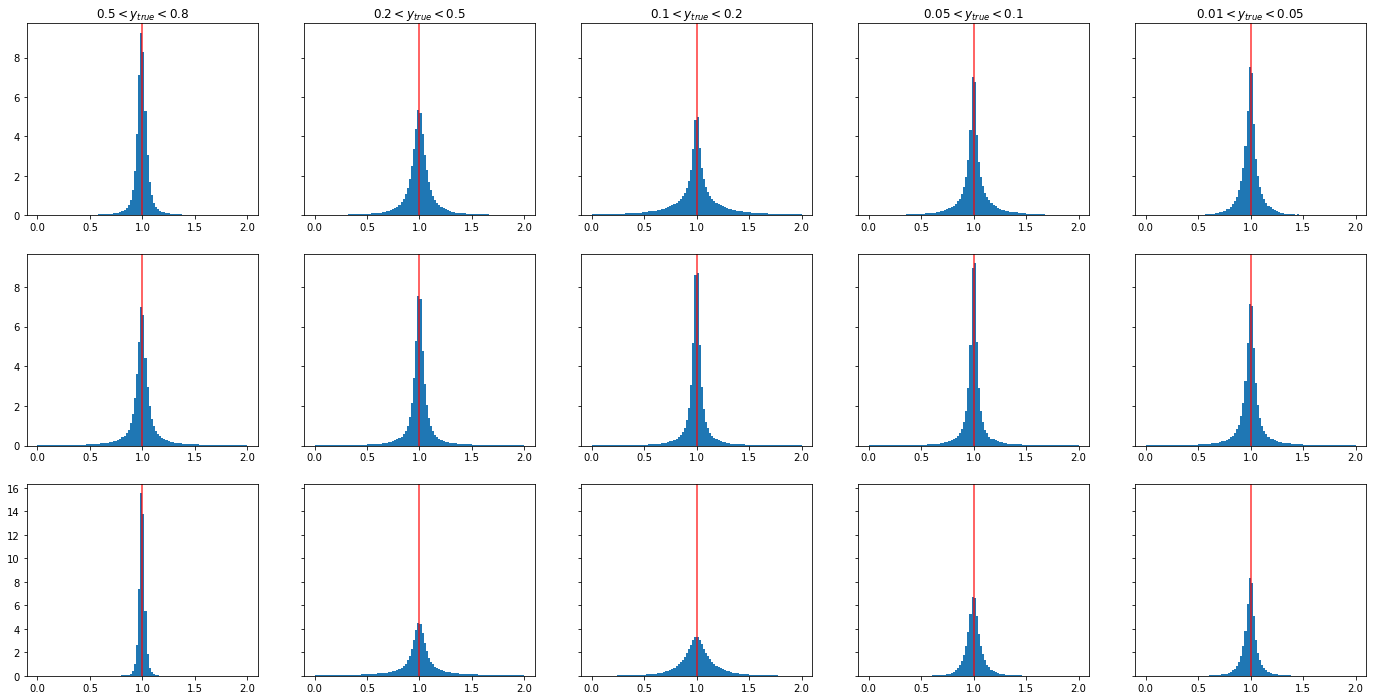

In [33]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


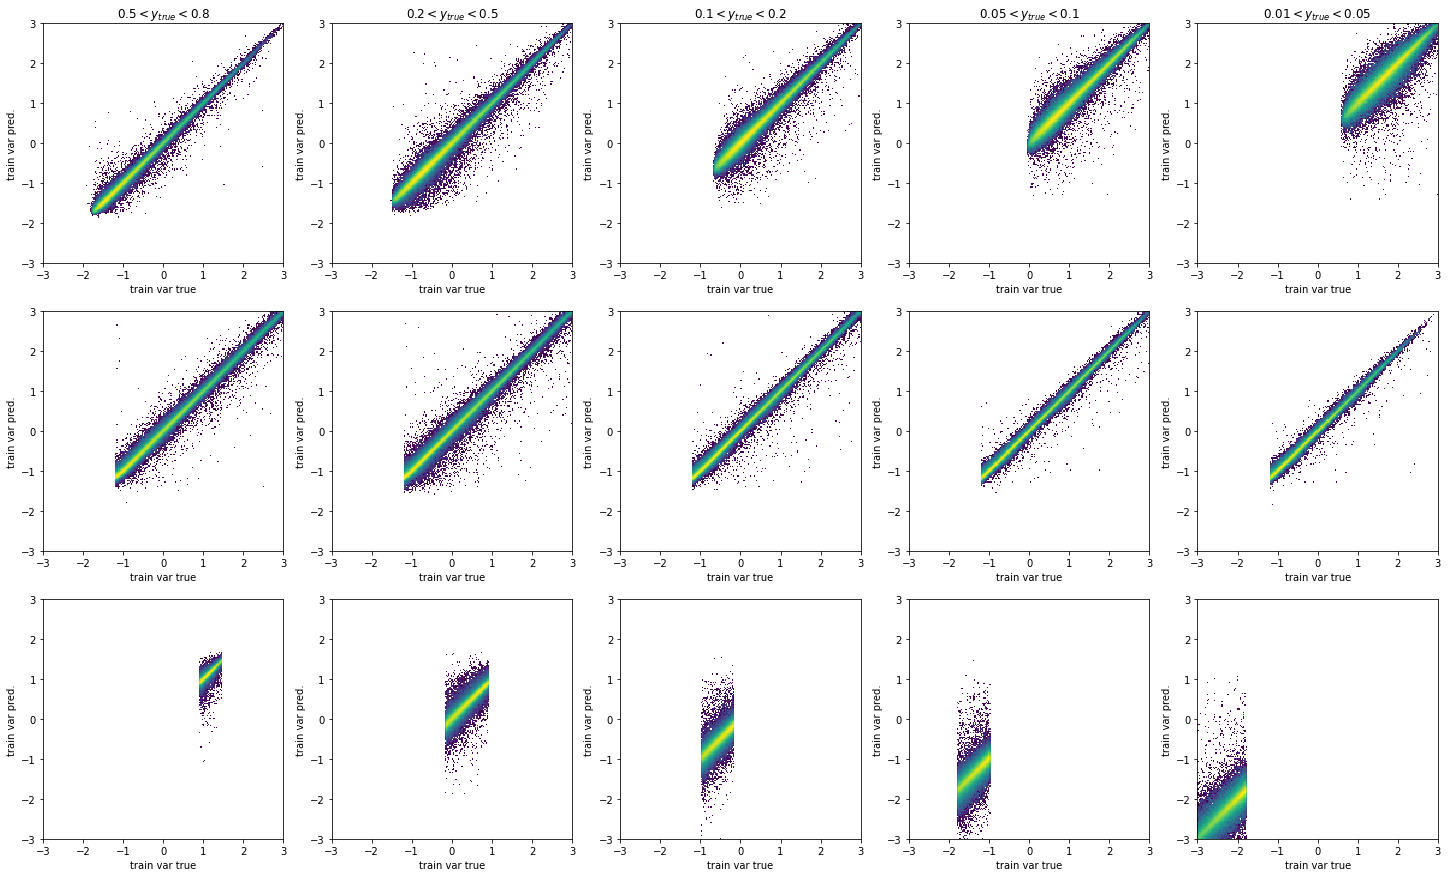

In [34]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

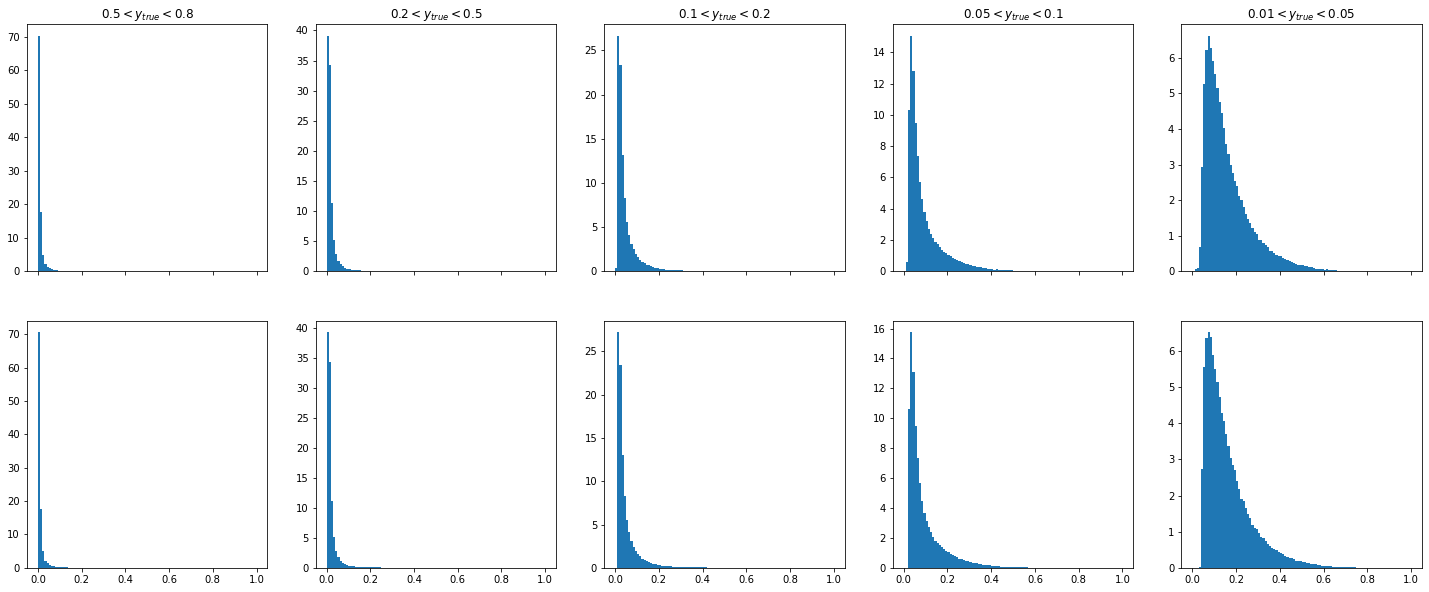

In [35]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

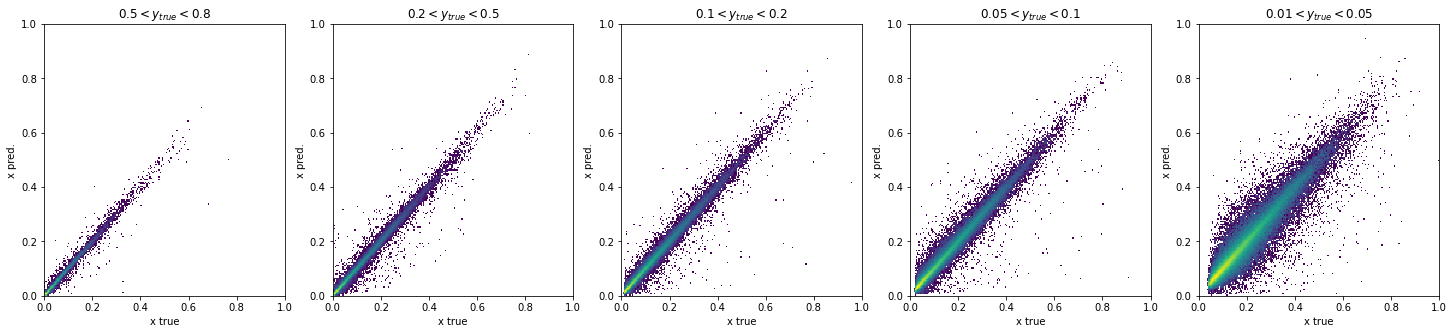

In [36]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

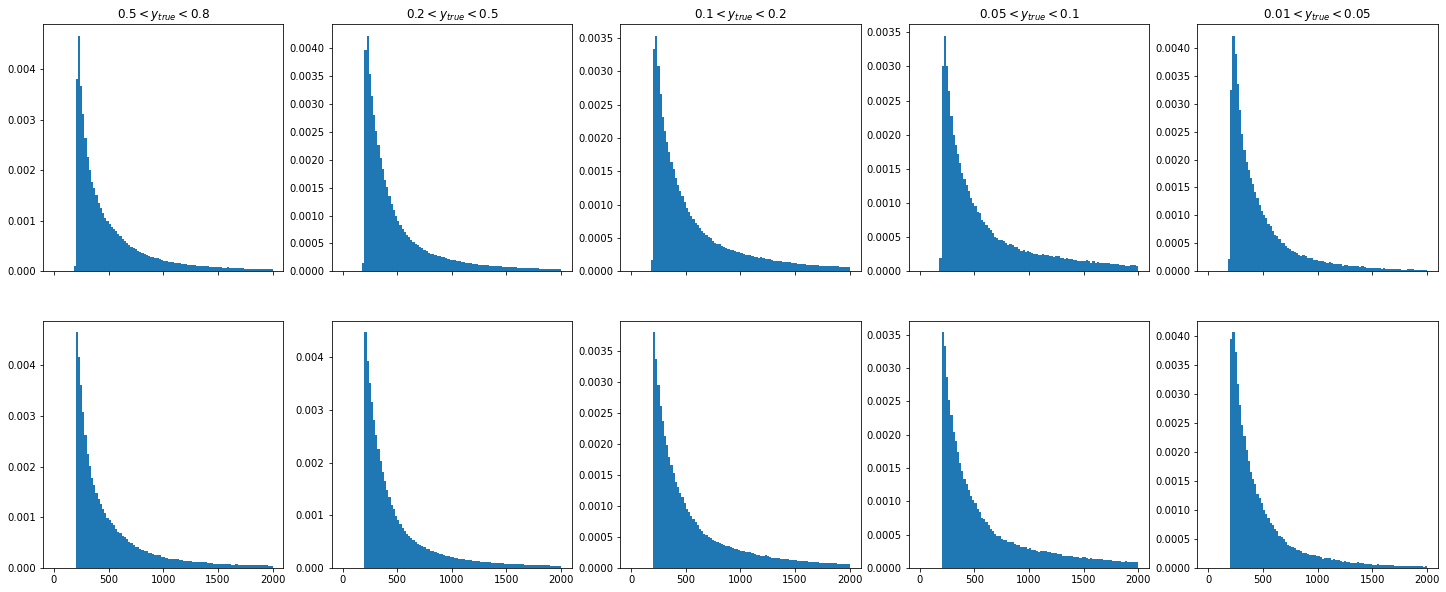

In [37]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

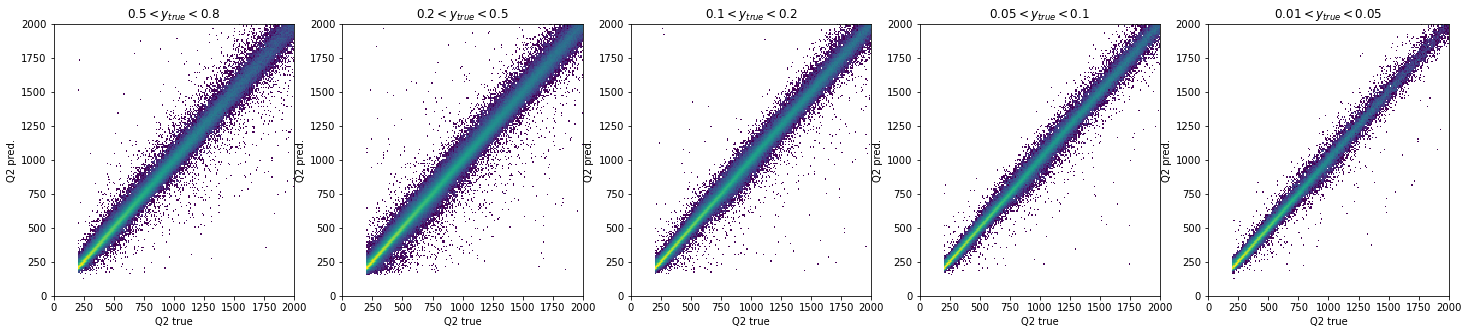

In [38]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

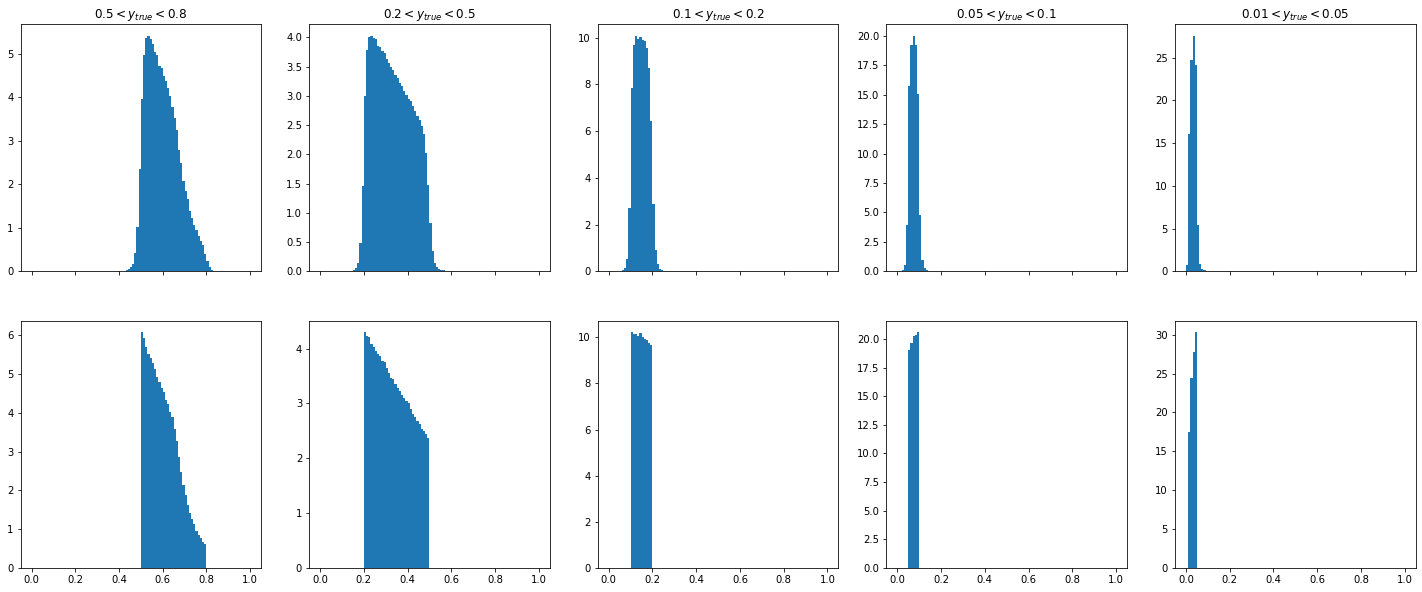

In [39]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

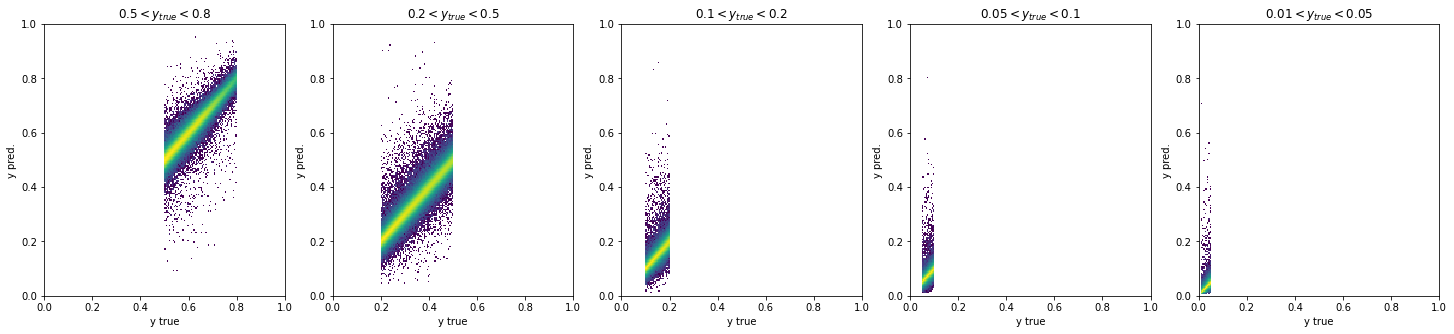

In [40]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

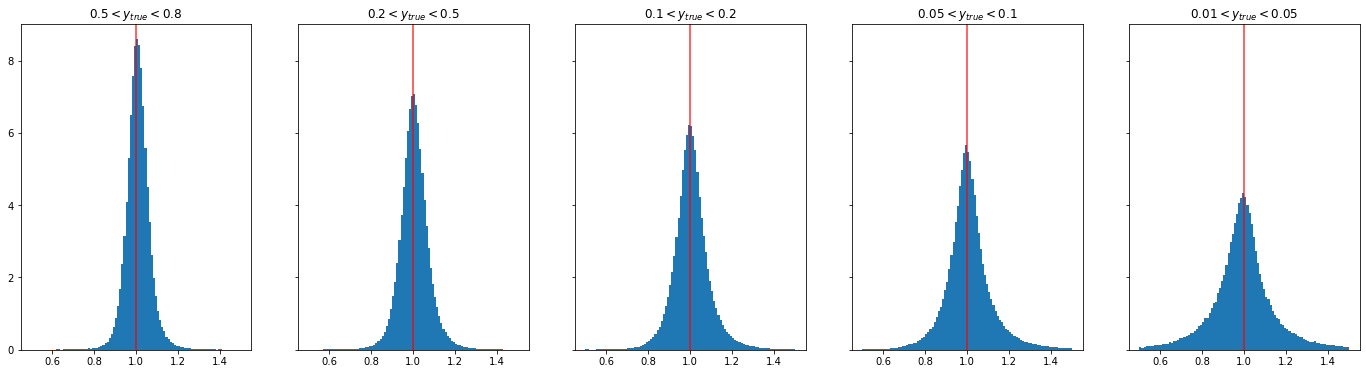

In [41]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

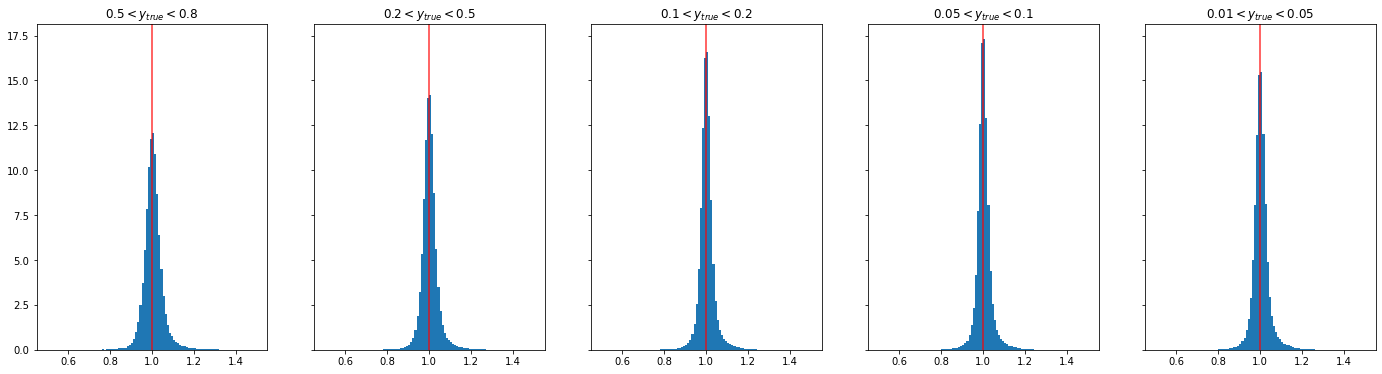

In [42]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

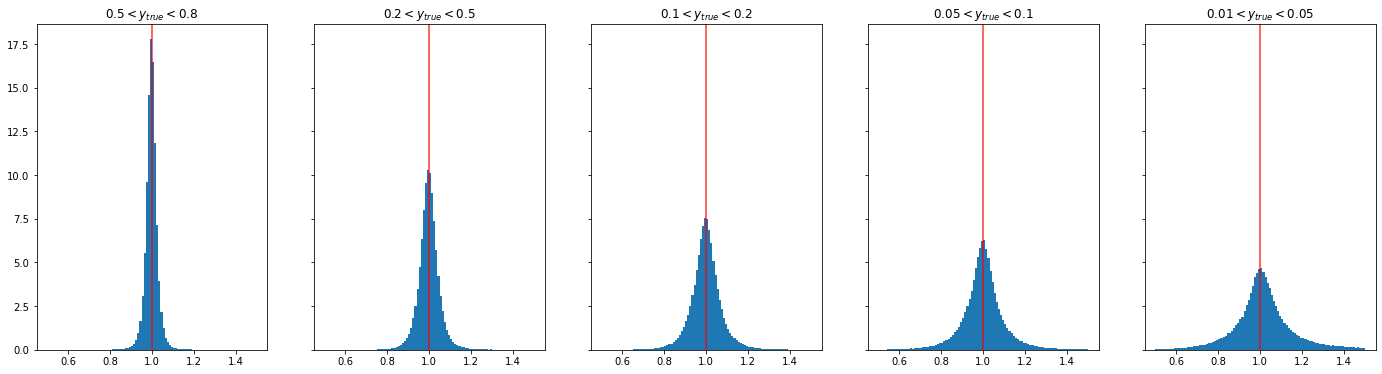

In [43]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  0,  5 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  0,  5 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  0,  5 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  0,  5 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  1,  4 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  1,  4 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  1,  4 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  1,  4 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  1,  4 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  2,  3 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  2,  3 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  2,  3 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  2,  3 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  2,  3 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  3,  0 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  3,  0 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  3,  0 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  3,  0 : gen_kine_ys>0.05 and gen_kine_y

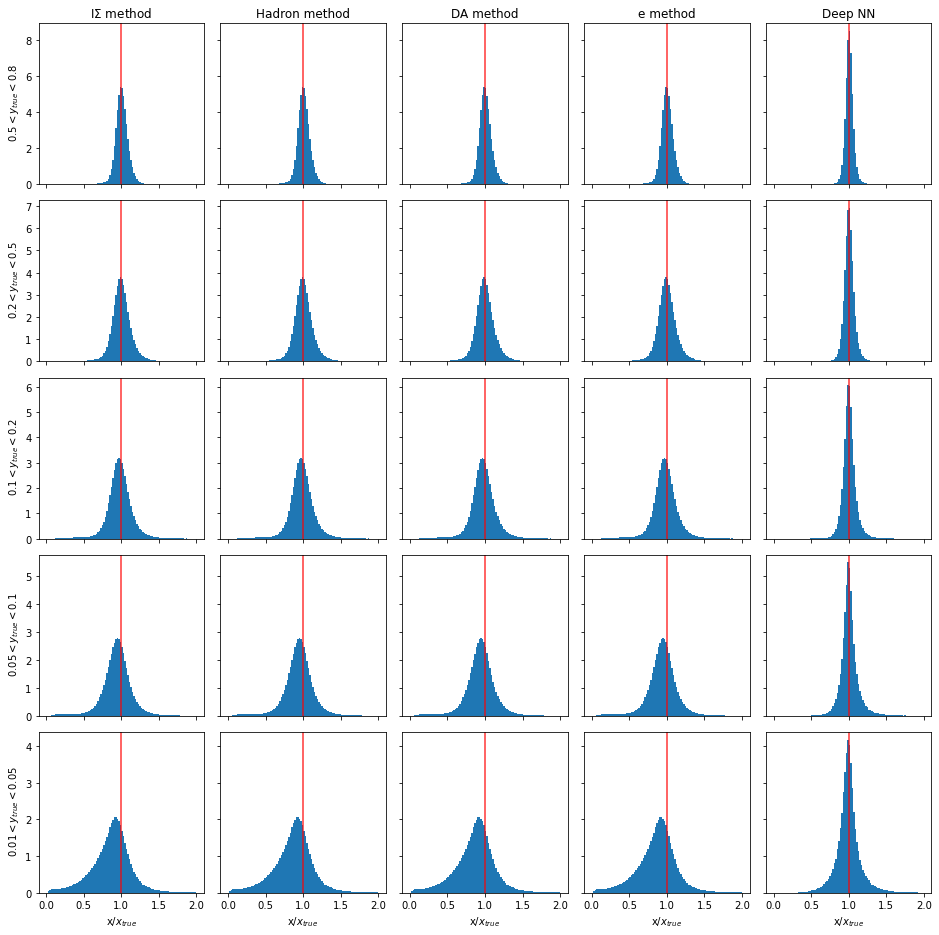

In [44]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.0
xmax = 2.0

#xmin = 0.5
#xmax = 1.5

y_cut = [
    'gen_kine_ys>0.50 and gen_kine_ys<0.80',
    'gen_kine_ys>0.20 and gen_kine_ys<0.50',
    'gen_kine_ys>0.10 and gen_kine_ys<0.20',
    'gen_kine_ys>0.05 and gen_kine_ys<0.10',
    'gen_kine_ys>0.01 and gen_kine_ys<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_xis']/pandas_df.query(y_cut[yi])['gen_kine_xis'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)


## resolution in Q2

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  0,  5 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  0,  5 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  0,  5 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  0,  5 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  1,  4 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  1,  4 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  1,  4 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  1,  4 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  1,  4 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  2,  3 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  2,  3 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  2,  3 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  2,  3 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  2,  3 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  3,  0 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  3,  0 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  3,  0 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  3,  0 : gen_kine_ys>0.05 and gen_kine_y

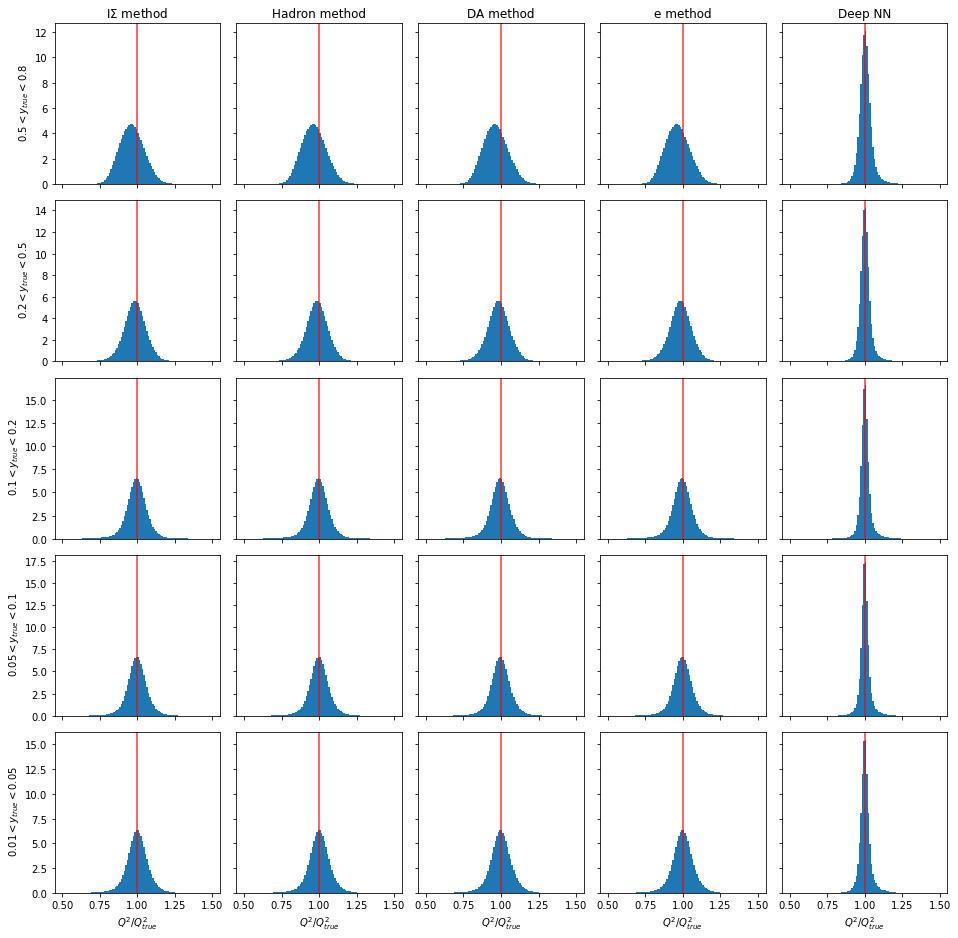

In [45]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

#y_cut = ....

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_Q2s' ]/pandas_df.query(y_cut[yi])['gen_kine_Q2s'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Resolution in y

   0,  0,  5 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  0,  5 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  0,  5 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  0,  5 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  0,  5 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  1,  4 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  1,  4 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  1,  4 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  1,  4 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  1,  4 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  2,  3 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  2,  3 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  2,  3 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  2,  3 : gen_kine_ys>0.05 and gen_kine_ys<0.10
   4,  2,  3 : gen_kine_ys>0.01 and gen_kine_ys<0.05
   0,  3,  0 : gen_kine_ys>0.50 and gen_kine_ys<0.80
   1,  3,  0 : gen_kine_ys>0.20 and gen_kine_ys<0.50
   2,  3,  0 : gen_kine_ys>0.10 and gen_kine_ys<0.20
   3,  3,  0 : gen_kine_ys>0.05 and gen_kine_y

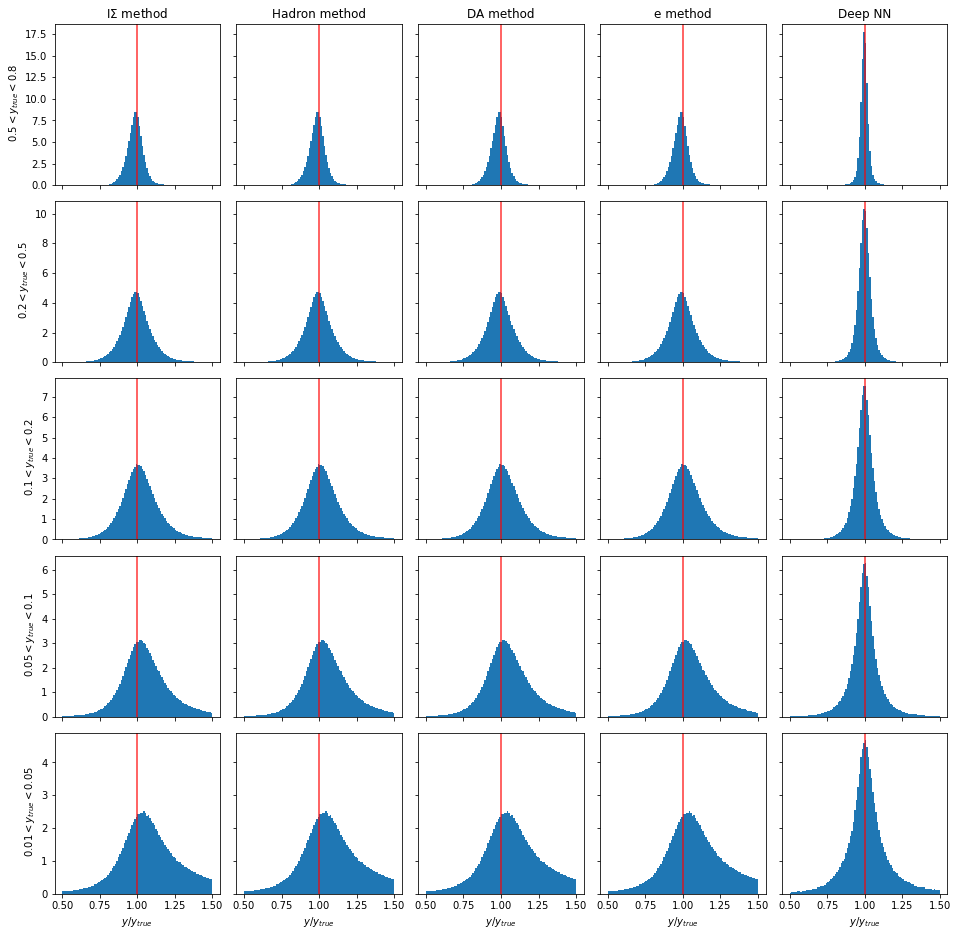

In [46]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

#y_cut = ..

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_kine_ys' ]/pandas_df.query(y_cut[yi])['gen_kine_ys'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)